![.../resources/cropped-SummerWorkshop_Header.png]

<h1 align="center"> Single Cell Encoding </h1> 
<h2 align="center"> SWDB 2024 - Day 2 - Morning Session </h2> 
<h3 align="center"> Tuesday, August 20, 2024</h3> 

In [1]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
# prefered magic functions for jupyter notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Neural Encoding </h2>

<p> High level description of neural encoding... what stimuli drive neural activity... 

Sensory coding is an obvious example that is easy to study - show stimulus then ask how neurons respond. 
But neurons encode more than external stimuli, they encode internal states, movements, choices, etc. 

Today we will look at how neurons in the visual cortex encode sensory and behavioral information in mice performing a visually guided task
</div>


## Outline & Questions

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> What we will learn today </h3>

<h4> Part 1 -  Visual Behavior Ophys Dataset</h4>

(1) What is the experimental design? What happens during a session? 

(2) What recording modality was used? What are the caveats of this modality?

(3) What data are available for analysis? Which cell populations were recorded? 

(4) How do you align different data streams? 


<h4> Part 2 -  Tuning for stimulus & behavior during task performance </h4>

(1) Are neurons in the mouse visual cortex selective for specific visual stimuli? How reliable are their responses?

(2) Do stimulus responses differ depending on the mouse's behavioral choice during the task? 

(3) Do neurons in the mouse visual cortex modulate their activity as a function of running speed? 


<h4> Part 3 -  Quantifying single cell coding with regression models </h4>

(1) How can linear regression be used to model neural coding? 

(2) How do you ensure that your model is valid and is not overfitting?

(3) How well can you predict neural activity based on stimulus information? Behavioral information? 

(4) Does the prediction improve when additional variables are included? (multiple linear regression)



## Part 1 - Visual Behavior Ophys Dataset

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
<h3> Experimental Design </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4> 2-photon calcium imaging </h4>
<p>All of out examples today will use the Allen Brain Observatory Visual Behavior Ophys dataset. 

"Ophys" stands for Optical Physiology, and typically refers to 2-photon calcium imaging of cellular activity (although there are other optical physiology methods!)

In this particular "Ophys" dataset, we used both single-plane and multi-plane 2-photon calcium imaging. With multi-plane imaging, we can record from up to 8 unique imaging planes (also called a field of view, or FOV) in the same session. 
</div>

Insert image of 2-photon imaging

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
<p>
Genetically encoded calcium indicators like GCaMP6 are what make calcium imaging possible. GCaMP is a protein that fluoresces when bound to calcium. 
Using genetic engineering, it is possible to create transgenic mice that express this calcium indicator in any genetically defined cell population of interest. 

In the Visual Behavior Ophys dataset, 3 types of transgenic mice were used to express GCaMP in either <b>excitatory neurons</b> (labeled by the Slc17a7-IRES2-Cre driver line), 
or in one of two types of <b>inhibitory neurons</b> - somatostatin (Sst) expressing neurons or vasoactive intestinal peptide (Vip) expressing neurons. 

These two inhibitory populations are known to mutually inhibit each other and a shift in the balance between them can lead to disinhibition of excitatory neurons under certain conditions.

You can read more about transgenic mice in the *DataBook*
</div>

Insert cre lines image

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4> Change detection task </h4>

<p>In this dataset, neural activity was recorded while mice performed a behaviorally guided task, specifically a visual change detection task. 

During the change detection task, mice view a continuous stream of natural scene images, which are displayed for 250ms, followed by a 500ms gray screen period. The gray screen period adds a working memory component to the task. The job of the mouse is to decide - "is what i am seeing now the same or different than what i saw 500ms ago?". 

If the mouse correctly responds by licking a reward spout within 750ms of an image change, the trial is considered a hit, and they get a water reward. If they fail to lick after a change, the trial is a miss. If the mouse licks anytime outside of the reward window, the trial resets and the mouse will have to wait longer until the next opportunity for a reward comes. 

</div>

Insert image of change detection task

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
While there is technically a trial structure imposed by the experimenter, such that an image change will occur following an exponential distribution between 4 and 12 flashes following the last lick, this is invisible to the mouse. The stimuli appear in a continuous stream with no breaks, and no trial start cue. One interesting question is whether mice form an internal model of the change time distribution and try to predict when the changes are most likely to happen. 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h5> Session structure </h5>
<p>
In addition to 60 minutes of change detection task performance, each ophys session has a few additional stimulus blocks that are useful for various purposes. 

Right before and right after the change detection task, there is a 5 minute period with a simple gray screen stimulus. 
This allows measurement of spontaneous activity levels in the absence of specific sensory stimuli.

At the very end of the session, a 30 second movie clip is shown 10 times. 
This can be helpful to drive activity in many neurons and aids in cell segmentation. 
It also allows activity patterns for the same stimulus to be compared across many days.

When looking at cell activity in the tutorial below, pay attention to the first 5 minutes and last 10 minutes of the session - does the activity look different during those time periods?


Insert image of session structure

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h5> Ophys sessions vs. behavior training sessions </h5>
<p>

Each `ophys_session` has a corresponding `behavior_session`, however not all `behavior_sessions` have Ophys.

The dataset also includes all of the `behavior_sessions` the mice experienced while they learned the change detection task, before the ophys portion of the experiment. These training sessions do not have 2-photon calcium imaging recordings. Neural activity was only measured once the mice were well trained. 

Mice learn the task through a series of automated training stages to help shape their behavior. There are many interesting questions about how mice learn the task that can be asked with this dataset, but we will not be focusing on those today.

Also note that behavior training sessions do not have the 5 minute spontaneous activity periods or repeated movie clip that was described above. Those stimulus blocks are only shown during ophys sessions.
</div>

Insert image of behavior training stages

The section below about cohorts & session types will be moved to the end of the notebook, as a prompt for exercises

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h4> Cohorts and session types</h4>
<p>

However, not all mice underwent the exact same training and imaging procedures. There are actually 4 unique cohorts of mice in the Visual Behavior Ophys dataset. 
These cohorts are distinguished by their `project_code`. The key differences between mice in these different cohorts (i.e. 'project codes') are: 
<p>

* Whether single-plane or multi-plane 2-photon imaging was performed
* Which areas and depths were imaged 
* Which image set was shown during training versus during ophys
</div>

Insert image of cohorts

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
<p>
These 4 cohorts of mice allow us to ask different questions, with slightly different variations on the experimental design. 
For example, for mice belonging to the <b>VisualBehavior</b> and <b>VisualBehaviorTask1B</b> cohorts, everything about the experiment was the same, except for which image set was used during training. 
This allows us to ask whether any differences in activity observed during the novel sessions are truly due to novelty, and not the unique features of the image set. 

The <b>VisualBehaviorMultiscope</b> cohort uses the same training procedure as <b>VisualBehavior</b>, but these mice were imaged using multi-plane 2-photon calcium imaging, meaning that up to 8 unique imaging planes could be recorded in each session.
The recordings for these mice were made in the primary (VISp) and secondary (VISl) visual areas, across 4 depths per area. 

The <b>VisualBehaviorMultiscope4areasx2d</b> cohort has a special twist - during ophys sessions when novel images are shown, there are also 2 familiar images interleaved. 
This allows comparison of familiar and novel image responses, and behavioral differences, within the same session. In contrast, in all other cohorts, familiar and novel stimuli are always in separate sessions. 
The Visual Behavior Neuropixels dataset shares this same design, using the same image sets for training and in vivo recordings.  
</div>

Insert image of ophys sessions, same cell tracking

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

During the 2-photon imaging phase of the experiment, a given population of neurons (i.e. a specific imaging plane) was measured across multiple sessions. 
This allows analysis of changes in neural activity across days, under different sensory and behavioral contexts. 
For example, in some ophys sessions, mice perform the task with the image set they saw during training, which is highly familiar. 
In other sessions, mice perform the task with images they have never seen before. 

This means we need to keep track of a few things when doing analysis: 
<p>

* Which type of session we are looking at (was it during training or during ophys? what image set was used?)
* Which imaging plane (i.e. population of neurons) we are looking at (what brain area is it in? what is the depth in the cortex?)
* Which type of cells are being imaged (what is the genotype of the mouse?)                                                                      

This information is provided as metadata by the <b>AllenSDK</b> toolkit, which you will learn how to use below                                                                                                                                         

</div>

Insert image of session vs. experiment vs. container

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

In the nomenclature of the <b>AllenSDK</b> we refer to each imaging plane within each session as an `ophys_experiment`.

The population of neurons in each imaging plane was tracked across multiple `ophys_sessions`, recorded on different days.

The collection of recording sessions belonging to a given imaging plane is called an `ophys_container`.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3>Accessing data with the AllenSDK</h3>
<p>

To identify experiments of interest based on the features of this dataset as described above, such as what cell populations were imaged, what types of sessions there were, etc., we need to access the metadata tables in the `VisualBehaviorOphysProjectCache` using the `AllenSDK` toolkit.

The `VisualBehaviorOphysProjectCache` class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded into data assets on CodeOcean - These data are big, and this will save us a lot of bandwidth and time.

</div>


In [3]:
# confirm that you are currently using the newest version of SDK (2.16.2)
import allensdk
allensdk.__version__

'2.16.2'

The code below shows you how to use the `VisualBehaviorOphysProjectCache` class to load metadata tables & explore the features of the dataset.

In [4]:
# This is the directory where files will be saved
# If using Code Ocean, this should link to the data directory, where the files will already be available
output_dir = r'/Users/marinag/Documents/Data/visual_behavior_ophys_cache_dir'

In [5]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=output_dir)

/Users/marinag/anaconda3/envs/swdb_2024/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/marinag/anaconda3/envs/swdb_2024/lib/python3.8/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[sti

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h3> Metadata tables </h3>


#### Load all cache tables

In [6]:
# There are 4 metadata tables associated with the Visual Behavior Ophys dataset
behavior_session_table = cache.get_behavior_session_table()  
ophys_session_table = cache.get_ophys_session_table()   
ophys_experiment_table = cache.get_ophys_experiment_table()    
ophys_cells_table = cache.get_ophys_cells_table()                         


#print number of items in each table 
print('Number of behavior sessions = {}'.format(len(behavior_session_table)))
print('Number of ophys sessions = {}'.format(len(ophys_session_table)))
print('Number of ophys experiments = {}'.format(len(ophys_experiment_table)))
print('Number of unique cells = {}'.format(len(ophys_cells_table.cell_specimen_id.unique())))

Number of behavior sessions = 4782
Number of ophys sessions = 703
Number of ophys experiments = 1936
Number of unique cells = 50476


What is the difference between the `ophys_session_table` and the `ophys_experiment_table`? 

In [7]:
ophys_experiment_table.head()

,behavior_session_id,ophys_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,...,passive,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,published_at,isi_experiment_id,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
951980471,951520319,951410079,1018028342,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,0
951980473,951520319,951410079,1018028345,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,1
951980475,951520319,951410079,1018028339,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,2
951980479,951520319,951410079,1018028354,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,3
951980481,951520319,951410079,1018028357,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,4


In [8]:
ophys_session_table.head()

,behavior_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,age_in_days,...,behavior_type,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,num_depths_per_area,ophys_experiment_id,num_targeted_structures
ophys_session_id,,,,,,,,,,,,,,,,,,,,,
951410079,951520319,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,...,active_behavior,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,4,"[951980471, 951980473, 951980475, 951980479, 9...",2
952430817,952554548,"[1018028339, 1018028345, 1018028354, 1018028357]",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,209,...,passive_viewing,Familiar,0,66,1,2019-09-23 08:45:38.490000+00:00,MESO.1,4,"[953659743, 953659745, 953659749, 953659752]",2
954954402,953982960,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,210,...,active_behavior,Familiar,0,67,2,2019-09-24 09:01:31.582000+00:00,MESO.1,4,"[958527464, 958527471, 958527474, 958527479, 9...",2
955775716,956010809,"[1018028339, 1018028342, 1018028345]",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,212,...,active_behavior,Familiar,1,68,3,2019-09-26 09:22:21.772000+00:00,MESO.1,4,"[956941841, 956941844, 956941846]",2
957020350,957032492,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,213,...,active_behavior,Novel 1,0,0,4,2019-09-27 08:58:37.005000+00:00,MESO.1,4,"[957759562, 957759564, 957759566, 957759570, 9...",2


The `ophys_experiment_table` contains one row for each imaging plane recorded in each session for all mice in the dataset. 

The `ophys_session_table` contains one row for each ophys session, which can contain one or more imaging planes. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
<p>
The metadata tables include a number of key details for understanding the dataset, such as - where the recordings were made, what type of cells were labeled, and what stimulus was shown in a given session. 

The *DataBook* describes all the columns of the metadata tables. We will explore a few of the most important ones here. 


First, let's narrow down our search and specifically look at the sessions for the <b>VisualBehaviorMultiscope</b> cohort. 

Filter the `ophys_session_table` to limit to the <b>VisualBehaviorMultiscope</b> `project_code` and assign the results to a new variable called `multiscope_sessions`.

How many mice are in this cohort? What mouse genotypes are available? (Hint: get the unique values of the `full_genotype` column)

In [9]:
# Limit to a specific cohort / project code and check how many mice there are
project_code = 'VisualBehaviorMultiscope'
multiscope_sessions = ophys_session_table[ophys_session_table.project_code==project_code]
print('There are', len(multiscope_sessions.mouse_id.unique()), 'mice in the', project_code, 'project_code')

There are 24 mice in the VisualBehaviorMultiscope project_code


In [10]:
# Check what genotypes are available for this cohort
print('Available genotypes:')
print(multiscope_sessions.full_genotype.unique())

Available genotypes:
['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'
 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt']


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h4>What is a genotype?</h4>
    
`full_genotype`: Calcium imaging only works if a calcium indicator (here GCaMP) is expressed in neurons so that calcium signals can be measures as changes in fluorescence. 
Transgenic mice are engineered to express these indicators in genetically defined cell populations. The 'full_genotype' of the mouse describes the strategy that was used to label a given cell population with GCaMP.

Typically, several transgenic lines of mice are bred together to create cell type specific expression by combining a <b>driver line</b> expressing Cre recombinase under the control of a specific gene of interest, and a <b>reporter line</b> that expresses some protein (such as GCaMP) under the control of Cre recombinase. This allows scientists to mix and match a variety of drivers & reporters to do different types of experiments. 

`cre_line`: is the first element of the `full_genotype` and determines which cell population is being targeted. 

`reporter_line`: is the second element of the `full_genotype` and determines what kind of reporter gene is expressed. In our case it is GCaMP, but other experiments may use a GFP reporter line, or a channelrhodopsin reporter line. 

You can learn more about transgenic mice and associated techniques in the <b>DataBook</b>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

What are the unique values of the `mouse_id` column for mice with `cre_line` = <b>Sst-IRES-Cre</b> in the `multiscope_sessions` table we just made?

Pick the mouse with the largest value of `mouse_id` and assign it to a new variable called `special_mouse_id`.

What are the available values of the `session_type` column for this mouse?

Note the data type of the `mouse_id` column.

In [11]:
# Filter by cre_line to get just the Sst mice, then print out the unique values of mouse_id, sorted in ascending order
cre_line = 'Sst-IRES-Cre'
sst_mice = multiscope_sessions[(multiscope_sessions.cre_line==cre_line)].mouse_id.unique()
print(np.sort(sst_mice))

['440631' '448366' '457841' '482853' '544965' '546605']


In [12]:
# This is our special mouse
special_mouse_id = '546605'

In [13]:
# Get all session types for special mouse
ophys_session_table[ophys_session_table.mouse_id==special_mouse_id].session_type.unique()

array(['OPHYS_1_images_A', 'OPHYS_2_images_A_passive', 'OPHYS_4_images_B',
       'OPHYS_5_images_B_passive', 'OPHYS_6_images_B'], dtype=object)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
<h4>What is a session type?</h4>

The `session_type` column is a short hand description that conveys a several pieces of information about what the mouse experienced during a given session, including:
<p>

* Whether the session was during <b>TRAINING</b> or <b>OPHYS</b> (the first element of the `session_type`)
* Which image set was shown during that session (the second element of the `session_type`)
* For <b>OPHYS</b> sessions, the last element of the `session_type` tells you whether the session was a <b>passive</b> viewing session where no rewards were delivered (if the session type doesnt say `passive` at the end, that means it was an active behavior session)
* For <b>TRAINING</b> sessions, the last element of the `session_type` provides a few other experimental details, like the volume of each reward delivered in that session

<p>
Other columns that provide valuable information about what happened during a session include: 
<p>

`image_set`: which image set was shown during that session

`behavior_type`: whether the session was <b>active behavior</b> or <b>passive viewing</b>

`experience_level`: whether the session used <b>Familiar</b> or <b>Novel</b> images, and whether it was the first novel day (`Novel 1`) or a subsequent novel day `Novel >1`

`prior_exposures_to_image_set`: how many prior sessions the mouse has experienced with the image set being shown during the current session (should always be zero for `Novel 1` sessions)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Compare the session types for special mouse in the `ophys_session_table` with the `behavior_session_table`. What is different?

In [14]:
# Check the session types for this mouse in the ophys_session_table
ophys_session_table[ophys_session_table.mouse_id==special_mouse_id].session_type.unique()

array(['OPHYS_1_images_A', 'OPHYS_2_images_A_passive', 'OPHYS_4_images_B',
       'OPHYS_5_images_B_passive', 'OPHYS_6_images_B'], dtype=object)

In [15]:
# Check the session types for this mouse in the behavior_session_table
behavior_session_table[behavior_session_table.mouse_id==special_mouse_id].session_type.unique()

array(['TRAINING_0_gratings_autorewards_15min', 'TRAINING_1_gratings',
       'TRAINING_2_gratings_flashed', 'TRAINING_3_images_A_10uL_reward',
       'TRAINING_4_images_A_training', 'TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_ready',
       'TRAINING_5_images_A_handoff_lapsed',
       'OPHYS_0_images_A_habituation', 'OPHYS_1_images_A',
       'OPHYS_2_images_A_passive', 'OPHYS_3_images_A', 'OPHYS_4_images_B',
       'OPHYS_5_images_B_passive', 'OPHYS_6_images_B'], dtype=object)

The `ophys_session_table` only includes data from OPHYS sessions, the `behavior_session_table` includes both OPHYS and TRAINING sessions

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Find the ophys session with `session_type` = `OPHYS_1_images_A` for our special mouse (`mouse_id` = `546605`). 

What are the values of  `experience_level` and `prior_exposures_to_image_set` for this session?

In [16]:
# Get the session metadata for special mouse with the session type listed above
sessions = ophys_session_table[(ophys_session_table.mouse_id==special_mouse_id) & 
                                (ophys_session_table.session_type=='OPHYS_1_images_A')]
sessions.head()

,behavior_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,age_in_days,...,behavior_type,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,num_depths_per_area,ophys_experiment_id,num_targeted_structures
ophys_session_id,,,,,,,,,,,,,,,,,,,,,
1080522184,1080558783,"[1079027842, 1079027847, 1079027857, 1079027861]",546605,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,181,...,active_behavior,Familiar,0,41,0,2021-02-02 09:56:33.243000+00:00,MESO.1,4,"[1080945462, 1080945465, 1080945468, 1080945471]",2


In [17]:
# What is the experience_level for this session?
sessions[['session_type', 'experience_level', 'prior_exposures_to_image_set']]

,session_type,experience_level,prior_exposures_to_image_set
ophys_session_id,,,
1080522184,OPHYS_1_images_A,Familiar,41


This is an Ophys session with Familiar images. Our special mouse has seen this image set during 41 prior behavior sessions.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Save the `ophys_session_id` for this session to a variable called `familiar_session_id`.

In [18]:
familiar_session_id = sessions.index.values[0]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h4>Where was imaging performed for this session?</h4>

Relevant metadata columns include: 

`imaging_depth`: Because Ca2+ imaging is an optical technique, recordings must be targeted to a specific focal depth of the microscope, corresponding to how deep in the tissue the images were collected. 
The values in the `imaging_depth` column indicate the distance from the cortical surface for each imaging plane that was recorded. 

`targeted_structure`: This is the brain area where the recording was made. 
In Allen Brain Observatory Ophys experiments, specific visual areas are targeted using Intrinsic Signal Imaging (ISI) to identify the boundaries of each visual area based on their reinotopic maps. You can learn more about this method in the <b>DataBook</b>.

As we saw previously, the `ophys_experiment_table` contains metadata for each individual image plane that was recorded in each session. Accordingly, information about which areas and depths were recorded can be found in the `ophys_experiment_table`, but not in the `ophys_session_table`. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Use the `ophys_experiment_table` to find all the imaging planes recorded in the `familiar_session_id` from our special mouse.

What `targeted_structures` were imaged? What are the available values of `imaging_depth`? What `equipment_name` was used to record this session?

In [19]:
# Get all recordings for session type OPHYS_1_images_A for our special mouse using the ophys_session_id we saved above
experiments = ophys_experiment_table[ophys_experiment_table.ophys_session_id==familiar_session_id]
experiments.head()

,behavior_session_id,ophys_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,...,passive,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,published_at,isi_experiment_id,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
1080945462,1080558783,1080522184,1079027842,546605,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,...,False,Familiar,0,41,0,2021-02-02 09:56:33.243000+00:00,MESO.1,2021-08-12,1056093655,505
1080945465,1080558783,1080522184,1079027847,546605,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,...,False,Familiar,0,41,0,2021-02-02 09:56:33.243000+00:00,MESO.1,2021-08-12,1056093655,506
1080945468,1080558783,1080522184,1079027857,546605,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,...,False,Familiar,0,41,0,2021-02-02 09:56:33.243000+00:00,MESO.1,2021-08-12,1056093655,507
1080945471,1080558783,1080522184,1079027861,546605,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),M,...,False,Familiar,0,41,0,2021-02-02 09:56:33.243000+00:00,MESO.1,2021-08-12,1056093655,508


In [20]:
# Print out the targeted structures and the imaging depths
print(experiments.targeted_structure.unique())
print(experiments.imaging_depth.unique())

['VISp' 'VISl']
[225 300 213]


In [21]:
# We can also look at both of these pieces of information at once by limiting the table just to those columns (plus a few others that might be interesting)
experiments[['targeted_structure', 'imaging_depth', 'session_type', 'experience_level', 'equipment_name']]

,targeted_structure,imaging_depth,session_type,experience_level,equipment_name
ophys_experiment_id,,,,,
1080945462,VISp,225,OPHYS_1_images_A,Familiar,MESO.1
1080945465,VISp,300,OPHYS_1_images_A,Familiar,MESO.1
1080945468,VISl,213,OPHYS_1_images_A,Familiar,MESO.1
1080945471,VISl,300,OPHYS_1_images_A,Familiar,MESO.1


In this session, recordings were made in VISp and VISl, at multiple cortical depths. However we only see 4 imaging planes here (each represented by a unique `ophys_experiment_id`) - shouldnt we expect 8 imaging planes per session for multi-plane imaging experiments? 

While it is true that 8 imaging planes are recorded in each multi-plane imaging session (acquired using the `MESO.1` or `MESO.2` microscopes), there are strict quality control (QC) criteria applied to each imaging plane. 

Some of the 8 planes can fail QC while others pass. Examples of QC criteria include: how much brain motion there was for a given plane or whether the signal to noise was too low to detect cells.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Get the `ophys_experiment_id` for the recording in `VISp` at `300`um depth, and save it to a variable called `ophys_experiment_id`

In [22]:
targeted_structure = 'VISp'
imaging_depth = 225
ophys_experiment_id = experiments[(experiments.targeted_structure==targeted_structure) & 
                                    (experiments.imaging_depth==imaging_depth)].index.values[0]
print(ophys_experiment_id)

1080945462


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h3> Physiology data </h3>

To load the data for a single imaging plane recorded in a given session, we can use the `get_behavior_ophys_experiment` method of the `VisualBehaviorOphysProjectCache` class that we instantiated previously as `cache`. 

This method returns a python object that contains all data and metadata for a given recording as attributes, along with some useful functions. We typically name this python object simply `dataset`.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Use the `ophys_experiment_id` we saved above as the input to the `get_behavior_ophys_experiment` method of the cache. 

Save the output to a variable called `dataset`. This is a python object that contains all the data for this imaging plane. 

Examine the `metadata` attribute.


In [23]:
# Load the dataset for the ophys_experiment_id we selected 
dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id)

/Users/marinag/anaconda3/envs/swdb_2024/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [24]:
# Look at the metadata attribute
dataset.metadata

{'equipment_name': 'MESO.1',
 'sex': 'M',
 'age_in_days': 181,
 'stimulus_frame_rate': 60.0,
 'session_type': 'OPHYS_1_images_A',
 'date_of_acquisition': datetime.datetime(2021, 2, 2, 9, 56, 33, 243000, tzinfo=tzutc()),
 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)',
 'cre_line': 'Sst-IRES-Cre',
 'behavior_session_uuid': UUID('75ef16e0-b427-4451-b872-cdcd74553968'),
 'driver_line': ['Sst-IRES-Cre'],
 'mouse_id': '546605',
 'project_code': 'VisualBehaviorMultiscope',
 'full_genotype': 'Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
 'behavior_session_id': 1080558783,
 'indicator': 'GCaMP6f',
 'emission_lambda': 520.0,
 'excitation_lambda': 910.0,
 'ophys_container_id': 1079027842,
 'field_of_view_height': 512,
 'field_of_view_width': 512,
 'imaging_depth': 225,
 'targeted_imaging_depth': 228,
 'imaging_plane_group': 0,
 'imaging_plane_group_count': 4,
 'ophys_experiment_id': 1080945462,
 'ophys_frame_rate': 11.0,
 'ophys_session_id': 1080522184,
 'targeted_structure': 'VISp'}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
<h4>What physiology data is provided?</h4>
<p>

`dff_traces`: dataframe containing normalized fluorescence traces for each cell. dF/F or dFF stands for 'delta fluorescence over baseline fluorescence', i.e. the change in fluorescence relative to each cell's baseline signal. 

`events`: dataframe containing calcium events detected from fluorescence signals. events are detected based on the rapid rise in calcium, typically associated with bursts of spikes. Events have a time and a magnitude, roughly equivalent to the spike rate of a neuron.

`ophys_timestamps`: time, in seconds, of each imaging frame of the 2-photon movie. The indices of `dff_traces` and `events` correspond to the times in the `ophys_timestamps` array. Note that the frame rate of the recordings can vary, with 30Hz being typical for single-plane imaging sessions, and 11Hz typical for multi-plane imaging.

`max_projection`: array of maximum intensity projection image of the 2-photon movie. Allows visualization of pixels with large changes in fluorescence, corresponding to active neurons.  

`average_projection`: array of average intensity projection image of the 2-photon movie. Allows visualization of average fluorescence across the 2-photon field of view. 

`roi_masks`: dataframe containing regions of interest corresponding to neuron cell bodies, segmented from the 2-photon movies. Each cell trace comes from one of the roi_masks.

`segmentation_mask_image`: array containing all segmented ROIs.

`cell_specimen_table`: dataframe containing cell ROI information

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot the `max_projection` and `segmentation_mask_image` this imaging plane. How many ROIs are there?

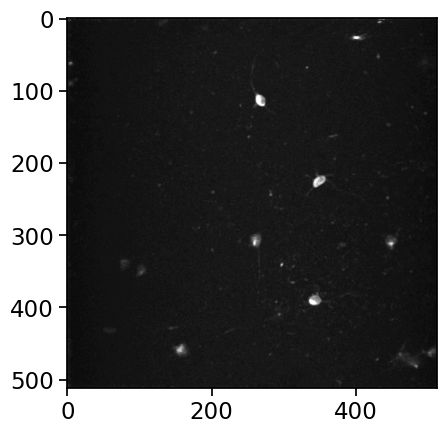

In [25]:
plt.imshow(dataset.max_projection, cmap='gray')

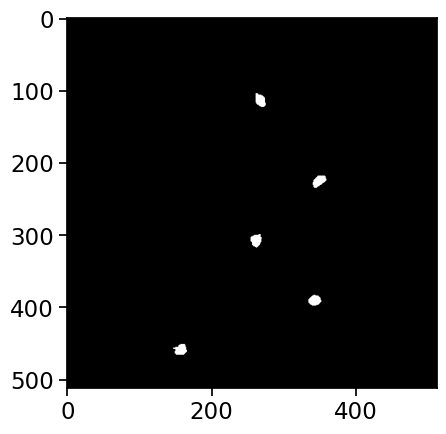

In [26]:
plt.imshow(dataset.segmentation_mask_image, cmap='gray')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Examine the `dff_traces` and `events` attributes. How are they formatted?


In [27]:
dataset.dff_traces.head()

,cell_roi_id,dff
cell_specimen_id,,
1120091374,1115349817,"[0.7160711781887898, 0.6762362443504489, 0.388..."
1120091421,1115349824,"[1.8867693532204104, 1.060213996273943, 0.6995..."
1120091574,1115349846,"[1.2439478189398283, 1.1846218118269713, 0.312..."
1120091628,1115349850,"[0.4401555247935194, 0.7162578934052323, 0.430..."
1120091659,1115349854,"[0.3687507608006909, 0.38771313157157544, 0.41..."


In [28]:
dataset.events.head()

,cell_roi_id,events,filtered_events,lambda,noise_std
cell_specimen_id,,,,,
1120091374,1115349817,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.1492,0.121036
1120091421,1115349824,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5322,0.228839
1120091574,1115349846,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.3728,0.191850
1120091628,1115349850,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.2187,0.146503
1120091659,1115349854,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.2117,0.144065


NOTE: need to pick one or the other description of events below, or a blend of the two

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h4> A note about event detection </h4>

Calcium signal is a continuous variable. We know, however, that most large influxes of calcium are associated with one or more spikes taking place in the neuron in question. These spikes are associated with a large influx of calcium into the cell, followed by a slow decay in the fluorescence signal. Importantly, this also presents a potential problem with calcium imaging; signals in the past contaminate signals in the future.

One solution to this problem is to do deconvolution of the calcium events from the time course of the df/f trace. Deconvolution is the process of separating two signals (in this case, the cell's response from the GCaMP and imaging dynamics). Deconvolution is a computationally hard and expensive problem. One such algorithm has already been run for us on these data. This algorithm makes some reasonable assumptions about the dynamics of df/f responses relative to calcium traces, and uses these to extract event times and event amplitudes from the df/f trace. A very excellent description of this method is here https://jewellsean.github.io/fast-spike-deconvolution/index.html. We will work with its outputs for the duration of this course.

A quick word on nomenclature: We don't actually know what caused a spike in calcium. It was most likely a single action potential or a burst of spikes in quick succession, but we did not explicitly observe these and do not know how many spikes there might have been. We therefore refer to calcium "events" as a source-agnostic way to describe this calcium activity.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

The ```events``` table is similar to ```dff_traces``` but the output provides traces of extrapolated events. Events are computed on spatially unmixed dff traces for each cell as described in [Giovannucci et al. 2019](https://pubmed.ncbi.nlm.nih.gov/30652683/). The magnitude of events approximates the firing rate of neurons with the resolusion of about 200 ms. The biggest advantage of using events over dff traces is they exclude prolonged Ca transients that may conteminate neural responses to subsequent stimuli. You can also use ```filtered_events``` which are events convolved with a filter created using ```stats.halfnorm``` method. 

```lambda``` is computed from Poisson distribution of events in the trace (think of it as a center of mass of the distribution, larger lambda == higher "firing rate").

```noise_std``` is a measure of variability in the events trace.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Pick one `cell_specimen_id` and plot dF/F and events for that cell, using `ophys_timestamps` for the y-axis values to show the time in seconds. 


In [29]:
# Get cell_specimen_id from the cell_specimen_table. Can also get from either the dff_traces or events
cell_specimen_ids = dataset.cell_specimen_table.index.values # a list of all cell ids
cell_specimen_id = cell_specimen_ids[0] # pick the first cell
print('Cell specimen id = {}'.format(cell_specimen_id)) # print the cell ID

Cell specimen id = 1120091374


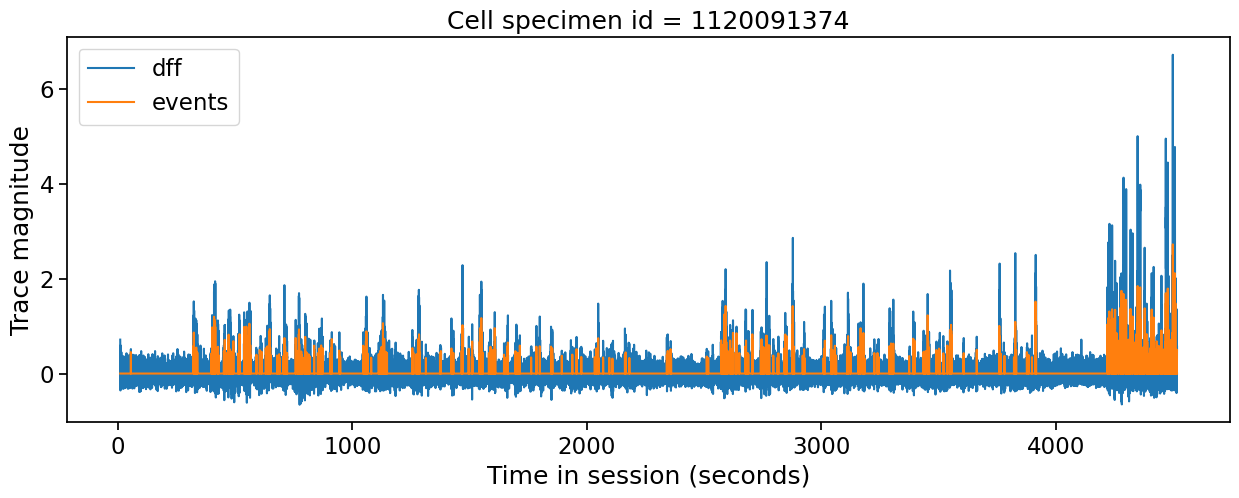

In [30]:
# Plot dff and events traces overlaid from the cell selected above
fig, ax = plt.subplots(1, 1, figsize = (15,5))
ax.plot(dataset.ophys_timestamps, dataset.dff_traces.loc[cell_specimen_id]['dff'], label='dff')
ax.plot(dataset.ophys_timestamps, dataset.events.loc[cell_specimen_id]['events'], label='events')
ax.set_xlabel('Time in session (seconds)')
ax.set_ylabel('Trace magnitude')
ax.set_title('Cell specimen id = {}'.format(cell_specimen_id))
ax.legend()


We can see that as expected, events trace is much cleaner than dff and it generally follows big calcium transients really well.

This cell is particularly active towards the end of the session - whats up with that? 

Recall that each Visual Behavior Ophys experiment has 10 repeats of a 30 second movie clip at the end of each session. 
It would be interesting to see how reliable the cell's response is across repeats of the movie. 

We can check what stimuli are presented and when using the `stimulus_presentations` table.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h3> Stimulus presentations </h3>

Each ophys session is broken up into several <b>stimulus blocks</b>.

First, a 5 minute gray screen period occurs during which there are no visual stimuli. This is helpful to determine cells' baseline level of activity. There is another 5 minute gray screen period at the end of the session, followed by 10 repeats of a 30 second movie clip. 

The bulk of each ophys session is change detection task performance, which lasts for 60 minutes. During the change detection task, 8 different images are shown, with each image being repeatedly presented for 250ms, followed by a 500ms gray screen period. The task of the mouse is to ask - "is what i am seeing now the same or different than what i saw 500ms ago?". 

If the mouse licks the reward spout during the 750ms reward window following an image change, they will receive a water reward. If the mouse licks anytime outside the reward window, the onset of the next trial, and thus the next image change and opportunity for reward, will be delayed. 

While there is a trial structure to the task, it is invisible to the mouse. The stimuli appear as a continuous stream with no interruption or trial start cue. Image change times are drawn from an exponential distribution between 4 and 12 flashes from the time of the mouse's last lick. 


Insert image of stim blocks

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Examine the `stimulus_presentations` attribute. What are the columns? 

What are the values of the `stimulus_block_name` column?

In [31]:
# What does the stimulus_presentations table look like? 
dataset.stimulus_presentations.head()

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,stimulus_name,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
0,0,initial_gray_screen_5min,-99,NaN,-99,309.366891,0.000000,309.366891,0,17985,False,<NA>,<NA>,-99,0,-99,False,spontaneous,False
1,1,change_detection_behavior,0,im065,-99,0.250210,309.366891,309.617101,17985,18000,False,False,False,-99,1,0,True,Natural_Images_Lum_Matched_set_training_2017,False
2,1,change_detection_behavior,0,im065,-99,0.250220,310.117501,310.367721,18030,18045,False,False,False,-99,2,0,True,Natural_Images_Lum_Matched_set_training_2017,False
3,1,change_detection_behavior,0,im065,-99,0.250190,310.868141,311.118331,18075,18090,False,False,False,-99,3,0,True,Natural_Images_Lum_Matched_set_training_2017,False
4,1,change_detection_behavior,0,im065,-99,0.250200,311.618751,311.868951,18120,18135,False,False,False,-99,4,0,True,Natural_Images_Lum_Matched_set_training_2017,False


In [32]:
# What are the stimulus blocks?
dataset.stimulus_presentations.stimulus_block_name.unique()

array(['initial_gray_screen_5min', 'change_detection_behavior',
       'post_behavior_gray_screen_5min', 'natural_movie_one'],
      dtype=object)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Assign the table to a new variable called `stimulus_table`, for short.

Select the `change_detection_behavior` block and look at the unique values of the `image_name` column for that block.

In [33]:
# Assign the table to a new variable
stimulus_table = dataset.stimulus_presentations.copy()

In [34]:
# Limit to change detection behavior block
stimulus_table = stimulus_table[stimulus_table.stimulus_block_name=='change_detection_behavior']
stimulus_table.head()

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,stimulus_name,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
1,1,change_detection_behavior,0,im065,-99,0.25021,309.366891,309.617101,17985,18000,False,False,False,-99,1,0,True,Natural_Images_Lum_Matched_set_training_2017,False
2,1,change_detection_behavior,0,im065,-99,0.25022,310.117501,310.367721,18030,18045,False,False,False,-99,2,0,True,Natural_Images_Lum_Matched_set_training_2017,False
3,1,change_detection_behavior,0,im065,-99,0.25019,310.868141,311.118331,18075,18090,False,False,False,-99,3,0,True,Natural_Images_Lum_Matched_set_training_2017,False
4,1,change_detection_behavior,0,im065,-99,0.25020,311.618751,311.868951,18120,18135,False,False,False,-99,4,0,True,Natural_Images_Lum_Matched_set_training_2017,False
5,1,change_detection_behavior,0,im065,-99,0.25022,312.369321,312.619541,18165,18180,False,False,False,-99,5,0,True,Natural_Images_Lum_Matched_set_training_2017,False


This table provides helpful information like image name, start, duration and stop of image presentation, and whether the image was omitted. 

In [35]:
# What are the image names?
stimulus_table.image_name.unique()

array(['im065', 'im077', 'im063', 'im062', 'im061', 'im066', 'omitted',
       'im069', 'im085'], dtype=object)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

What are the stimuli that were shown?

Check out the `stimulus_templates` attribute of the dataset object. Plot each of the images using the `unwarped` column of the table. 

In [36]:
stimuli = dataset.stimulus_templates.copy()
stimuli


,unwarped,warped
image_name,,
im065,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[198, 197, 201, 207, 207, 202, 198, 201, 207,..."
im077,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[129, 135, 140, 142, 140, 135, 129, 124, 117,..."
im066,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[83, 85, 82, 78, 78, 81, 84, 84, 82, 82, 84, ..."
im061,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[125, 126, 126, 126, 125, 125, 125, 125, 125,..."
im063,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[105, 108, 107, 101, 97, 96, 98, 101, 103, 10..."
im062,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[103, 103, 103, 105, 112, 125, 145, 172, 204,..."
im085,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[54, 56, 50, 45, 45, 51, 56, 55, 51, 48, 49, ..."
im069,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[251, 248, 255, 255, 255, 254, 246, 248, 255,..."


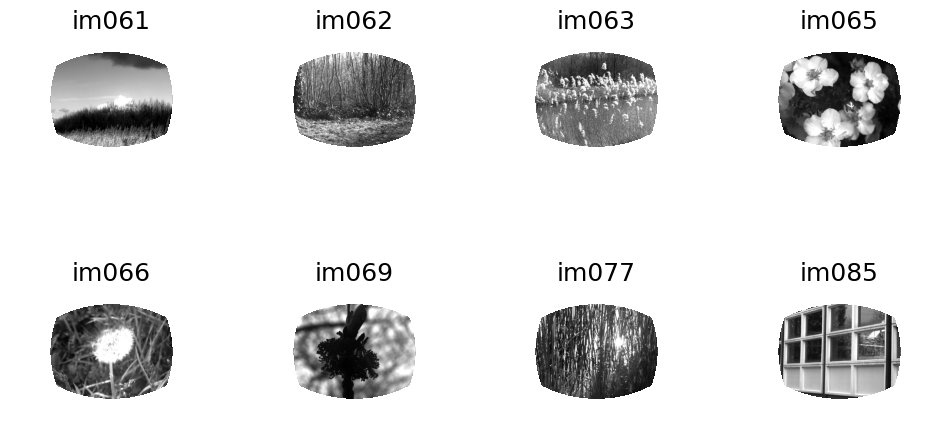

In [37]:
# Plot the unwarped stimuli
fig, ax = plt.subplots(2,4, figsize=(12,6))
ax = ax.ravel()
for i, image_name in enumerate(np.sort(stimuli.index.unique())): 
    ax[i].imshow(stimuli.loc[image_name]['unwarped'], cmap='gray')
    ax[i].set_title(image_name)
    ax[i].axis('off')

Why are the images curved like that? Whats the difference between `warped` and `unwarped` images in this table?

The stimuli presented to the mouse are warped using a spherical coorrection to account for the variable distance of the mouse's eye from the flat visual display monitor. 
If we had used a spherical dome for stimulus display, we wouldnt need to do this. But since the screen is flat, we need to adjust the size of the stimulus towards the edges of the screen to make sure it looks consistent to the mouse at a distance.

You can learn more about the spherical correction in the <b>DataBook</b>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h4> Image changes and image omissions </h4>

You may have noticed that one of the values of `image_name` is "omitted". 
That is because some image presentations are randomly omitted during ophys sessions (but never during training).
This allows neural signals associated with the absence of an expected stimulus to be analyzed. 

The `omitted` column of the `stimulus_presentations` table provides a useful Boolean value to filter by omissions. 

Another useful column is the `is_change` column, which is another Boolean value. 
This can be used to identify the image changes, which are the "go" trials of this task. 

You can also look at "no-go" or "catch" trials using the `is_sham_change` column. 
This column is True for all image presentations that could have been a change, according to the exponential distribution of change times. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

How many unique `stimulus_presentations` are there in this session?

How many image changes were there? How many stimuli were omitted? 

In [38]:
# Count all stimulus presentations
print(len(stimulus_table), 'stimulus presentations total')

# Count the changes
print(len(stimulus_table[stimulus_table.is_change==True]), 'stimulus presentations were changes')

# Count the omissions
print(len(stimulus_table[stimulus_table.omitted==True]), 'stimulus presentations were omitted')

4806 stimulus presentations total
312 stimulus presentations were changes
179 stimulus presentations were omitted


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h4> Timestamps </h4>

Now that we know how to get the stimuli for this session, we want to ask how neurons respond to different types of stimuli. 
This means we need to know when a given stimulus happened relative to the neural recordings. 

All the data in each session was recorded on a common clock, however not all data streams were sampled at the same rate. 
Let's examine the timestamps to understand the differences


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Examine the `stimulus_timestamps` attribute. Compare it to the values of `ophys_timestamps`. Are they the same? 

Compute the frame rate of each set of timestamps by using `np.diff` to get the inter-frame interval. The frame rate is 1 divided by the average inter-frame interval. 

In [39]:
# Stimulus timestamps
dataset.stimulus_timestamps

array([   9.3354 ,    9.35208,    9.36877, ..., 4517.55163, 4517.5683 ,
       4517.58498])

In [40]:
# Ophys timestamps
dataset.ophys_timestamps

array([   9.31877,    9.41227,    9.50577, ..., 4517.38987, 4517.4834 ,
       4517.57693])

In [41]:
# Stimulus frame rate
1/np.mean(np.diff(dataset.stimulus_timestamps))

59.95031889960272

In [42]:
# Ophys frame rate
1/np.mean(np.diff(dataset.ophys_timestamps))

10.692377918304482

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h3> Aligning stimulus & phyisology data </h3>

As we saw above, the ophys data and stimulus presentations are not recorded at the same rate. 
If we want to compute stimulus aligned cell activity, we will need a way to associate ophys timestamps with the nearest stimulus timestamps. 

Fortunately, the `brain_observatory_utilities` package provides tools to make this easier. 

There are to main modules in this repo that are useful for aligning different timeseries: 

`datasets.optical_physiology.data_formatting`: provides tools for reformatting ophys data (events and dff traces) to align to stimulus times. We will use this module below.

`utilities.general_utilities`: provides tools for general purpose slicing and dicing of timeseries data, provided it is in the expected format. This module contains the functions that `data_formatting` relies on to work, and can be useful for other types of data as well (like electrophysiology). We wont be using this module right now, but see the mini-tutorial at the end of the notebook for more info about it. 

In [43]:
import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h4> Get stimulus response dataframe </h4>

We can use the `get_stimulus_response_df` function from the `datasets.optical_physiology.data_formatting` module to get the stimulus locked activity for all cells in the dataset. 

Let's look at the documentation for this function


In [44]:
# Let's look at the documentation for the get_stimulus_response_df function
data_formatting.get_stimulus_response_df?

Signature:
data_formatting.get_stimulus_response_df(
    ophys_experiment,
    data_type='dff',
    event_type='all',
    time_window=[-3, 3],
    response_window_duration=0.5,
    interpolate=True,
    output_sampling_rate=None,
    exclude_invalid_rois=True,
    **kwargs,
)
Docstring:
Get stimulus aligned responses from one ophys_experiment.

Parameters:
___________
ophys_experiment: obj
    AllenSDK BehaviorOphysExperiment object
    A BehaviorOphysExperiment instance
    See https://github.com/AllenInstitute/AllenSDK/blob/master/allensdk/brain_observatory/behavior/behavior_ophys_ophys_experiment.py  # noqa E501
data_type: str
    neural or behavioral data type to extract, options are: dff (default), events, filtered_events, running_speed, pupil_diameter, lick_rate
event_type: str
    event type to align to, which can be found in columns of ophys_experiment.stimulus_presentations df.
    options are: 'all' (default) - gets all stimulus trials
                 'images' - gets only im

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

The `get_stimulus_response` function is smart and already knows what our data structures look like, 
so it can pull out the relevant information from the cell activity tables (`dff_traces` and `events`) 
and from the `stimulus_presentations` table.

The `ophys_experiment` argument to the `get_stimulus_response` function is an instance of the dataset object that we have been working with.

The `data_type` argument is which cell timeseries you want to use, either 'dff', 'events', or 'filtered_events'.

The `event_type` argument can be used to sub-select the `stimulus_presentations` table. 
If `all` is provided, the function will get stimulus locked responses for every stimulus presentation over the entire session.
If `event_type` = `changes`, only image changes will be sampled. 
If `event_type` = `omissions`, only omissions will be sampled. 

The `time_window` argument is the time, in seconds, around each event over which you would like to sample the cell traces. 
It is formatted as an array of 2 values with time before and time after, such as [-1,1].

The `response_window_duration` is the duration, in seconds, following the stimulus onset time over which you would like to compute an average image evoked response. If `response_window_duration` is 0.5 seconds, the average of the dff or events trace in a 500ms window following stimulus onset will be computed stimulus presentation, resulting in a single value representing the mean response for each cell on each trial. 

If the `interpolate` argument is set to `True` (which is the default value), and a value is also provided for `output_sampling_rate`, 
the `event_triggered_response` funciton will automatically interpolate the timeseries provided in `data` to the provided `output_sampling_rate`. Setting `interpolate` to `False` means that the native frame rate of the data will be used. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Use the `get_stim_response_df` function from the `data_formatting` module to get stimulus aligned dff traces for image changes.

What are the columns of the table that is returned?

In [45]:
stim_response_df = data_formatting.get_stimulus_response_df(dataset, data_type='dff', event_type='changes',
                                                            time_window=[-1, 1], response_window_duration=0.5,
                                                            interpolate=True, output_sampling_rate=None)
stim_response_df.head()

100%|██████████| 5/5 [00:00<00:00, 33.93it/s]


,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,ophys_frame_rate,data_type,event_type,interpolate,output_sampling_rate,response_window_duration
0,6,1120091374,"[0.19085277005886073, 0.137596169444131, 0.072...","[-1.0, -0.9812953973048327, -0.962590794609665...",-0.003801,-0.199444,1.0000,11.0,dff,changes,True,None,0.5
1,6,1120091421,"[0.48840686539676137, 0.3530434775614892, 0.18...","[-1.0, -0.9812953973048327, -0.962590794609665...",0.149290,0.677295,0.1192,11.0,dff,changes,True,None,0.5
2,6,1120091574,"[0.24356709898964402, 0.17129044011636796, 0.0...","[-1.0, -0.9812953973048327, -0.962590794609665...",-0.025808,0.035858,1.0000,11.0,dff,changes,True,None,0.5
3,6,1120091628,"[0.056318280662376666, 0.07252829447572301, 0....","[-1.0, -0.9812953973048327, -0.962590794609665...",-0.059708,-0.096352,1.0000,11.0,dff,changes,True,None,0.5
4,6,1120091659,"[-0.1306041601915834, -0.10244394702518009, -0...","[-1.0, -0.9812953973048327, -0.962590794609665...",0.036208,0.080565,0.1487,11.0,dff,changes,True,None,0.5


Note that the stim_response_df contains the index of the `stimulus_presentations` table, the `stimulus_presentations_id`. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Add stimulus metadata by merging the `stimulus_response_df` and the `stimulus_table` using the `stimulus_presentations_id` column. 

Check the documentation for the `pandas.merge` function if you are unsure how to use it. https://pandas.pydata.org/docs/reference/api/pandas.merge.html 

In [46]:
stim_response_df = stim_response_df.merge(stimulus_table, on='stimulus_presentations_id')
stim_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,ophys_frame_rate,data_type,event_type,...,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,stimulus_name,is_sham_change
0,6,1120091374,"[0.19085277005886073, 0.137596169444131, 0.072...","[-1.0, -0.9812953973048327, -0.962590794609665...",-0.003801,-0.199444,1.0000,11.0,dff,changes,...,18225,True,False,False,-99,0,0,True,Natural_Images_Lum_Matched_set_training_2017,False
1,6,1120091421,"[0.48840686539676137, 0.3530434775614892, 0.18...","[-1.0, -0.9812953973048327, -0.962590794609665...",0.149290,0.677295,0.1192,11.0,dff,changes,...,18225,True,False,False,-99,0,0,True,Natural_Images_Lum_Matched_set_training_2017,False
2,6,1120091574,"[0.24356709898964402, 0.17129044011636796, 0.0...","[-1.0, -0.9812953973048327, -0.962590794609665...",-0.025808,0.035858,1.0000,11.0,dff,changes,...,18225,True,False,False,-99,0,0,True,Natural_Images_Lum_Matched_set_training_2017,False
3,6,1120091628,"[0.056318280662376666, 0.07252829447572301, 0....","[-1.0, -0.9812953973048327, -0.962590794609665...",-0.059708,-0.096352,1.0000,11.0,dff,changes,...,18225,True,False,False,-99,0,0,True,Natural_Images_Lum_Matched_set_training_2017,False
4,6,1120091659,"[-0.1306041601915834, -0.10244394702518009, -0...","[-1.0, -0.9812953973048327, -0.962590794609665...",0.036208,0.080565,0.1487,11.0,dff,changes,...,18225,True,False,False,-99,0,0,True,Natural_Images_Lum_Matched_set_training_2017,False


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

What columns exist in your new `stimulus_response_df`? 

What are the values of the `is_change` column (which we added via the merge function above)?

What are the values of the `trace_timestamps` column? Are they all the same? What are they referenced to? 

In [47]:
# Check out the columns available
stim_response_df.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'trace',
       'trace_timestamps', 'mean_response', 'baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       'interpolate', 'output_sampling_rate', 'response_window_duration',
       'stimulus_block', 'stimulus_block_name', 'image_index', 'image_name',
       'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'trials_id', 'active',
       'stimulus_name', 'is_sham_change'],
      dtype='object')

In [48]:
stim_response_df.is_change.unique()

array([ True])

In [49]:
# Whats up with the timestamps
stim_response_df.trace_timestamps

0       [-1.0, -0.9812953973048327, -0.962590794609665...
1       [-1.0, -0.9812953973048327, -0.962590794609665...
2       [-1.0, -0.9812953973048327, -0.962590794609665...
3       [-1.0, -0.9812953973048327, -0.962590794609665...
4       [-1.0, -0.9812953973048327, -0.962590794609665...
                              ...                        
1555    [-1.0, -0.9812953973048327, -0.962590794609665...
1556    [-1.0, -0.9812953973048327, -0.962590794609665...
1557    [-1.0, -0.9812953973048327, -0.962590794609665...
1558    [-1.0, -0.9812953973048327, -0.962590794609665...
1559    [-1.0, -0.9812953973048327, -0.962590794609665...
Name: trace_timestamps, Length: 1560, dtype: object

In [50]:
stim_response_df.trace_timestamps.values[0]

array([-1.        , -0.9812954 , -0.96259079, -0.94388619, -0.92518159,
       -0.90647699, -0.88777238, -0.86906778, -0.85036318, -0.83165858,
       -0.81295397, -0.79424937, -0.77554477, -0.75684016, -0.73813556,
       -0.71943096, -0.70072636, -0.68202175, -0.66331715, -0.64461255,
       -0.62590795, -0.60720334, -0.58849874, -0.56979414, -0.55108954,
       -0.53238493, -0.51368033, -0.49497573, -0.47627112, -0.45756652,
       -0.43886192, -0.42015732, -0.40145271, -0.38274811, -0.36404351,
       -0.34533891, -0.3266343 , -0.3079297 , -0.2892251 , -0.27052049,
       -0.25181589, -0.23311129, -0.21440669, -0.19570208, -0.17699748,
       -0.15829288, -0.13958828, -0.12088367, -0.10217907, -0.08347447,
       -0.06476987, -0.04606526, -0.02736066, -0.00865606,  0.01004855,
        0.02875315,  0.04745775,  0.06616235,  0.08486696,  0.10357156,
        0.12227616,  0.14098076,  0.15968537,  0.17838997,  0.19709457,
        0.21579918,  0.23450378,  0.25320838,  0.27191298,  0.29

Looks like the timestamps go from -1 to 1 second around the stimulus onset time, just like we asked for when we ran the `get_stimulus_response_df` function!! 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot the average image change evoked response for the `cell_specimen_id` we selected earlier, using the `trace` and `trace_timestamps` columns.

Text(0, 0.5, 'dF/F')

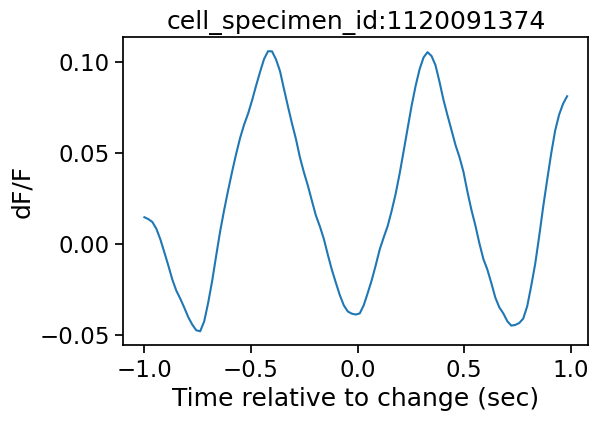

In [51]:
# Plot the average response for the cell we care about

# get the relevant data
cell_df = stim_response_df[stim_response_df.cell_specimen_id==cell_specimen_id]
# get the average dff trace
mean_trace = cell_df.trace.mean()
# get the timestamps for one row ()
timestamps = cell_df.trace_timestamps.values[0]

# make the plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(timestamps, mean_trace)
ax.set_title('cell_specimen_id:'+str(cell_specimen_id))
ax.set_xlabel('Time relative to change (sec)')
ax.set_ylabel('dF/F')


Looks like this cell increases its activity following image onset, but the response to the image change and the repeated image before the change are pretty similar. I wonder if thats a property of all Sst neurons, or just this one...

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Hurray!! We can exact stimulus evoked responses! Now we can finally start asking the questions we outlined at the beginning!! 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Part 2 -  Tuning for stimulus & behavior during task performance </h2>

(1) Are neurons in the mouse visual cortex selective for specific visual stimuli? How reliable are their responses?

(2) Do stimulus responses differ depending on the mouse's behavioral choice during the task? 

(3) Do neurons in the mouse visual cortex modulate their activity as a function of running speed? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

To understand sensory tuning, we want to know how individual cells respond to different stimuli. We will test this out first.

To understand the impact of behavior on single cell coding, we could take a few different approaches. 

One aspect of <b>behavior</b>  is the animals behavioral choice during the task. 
We could ask whether stimulus tuning, or overall cell activity, is different for image changes when the mouse correctly responds to the change with a lick and got a reward(i.e. a <b>hit</b> trial), compared with changes where the mouse failed to respond (i.e. <b>miss</b> trials)

Another aspect of <b>behavior</b> is the animals overall behavioral state, such as whether they are <b>running</b> or <b>stationary</b>. 
Here we could ask whether a given cell's activity level is modulated by the overall speed of the mouse (i.e. are cells "tuned" for running speed?)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h3> Stimulus tuning & response reliability </h3>

Let's start by asking whether individual cells respond differently to the 8 different images shown in each Visual Behavior Ophys session

Then we will evaluate how consistent that response is, and whether it is statistically valid to claim that the cell "encodes" a given image. 

Let's revisit the `stimulus_response_df` for the `cell_specimen_id` we are interested in.

The `mean_response` column contains the average value of the dF/F signal (which is what we provied as the `data_type` to the `get_stimulus_response_df` function - we could replace that with `events` to use deconvolved events instead) in a pre-defined window of time following the stimulus onset (determined by the value of `response_window_duration` provided to the `get_stimulus_response_df` function above). 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Get the average value of the `mean_response` column for each unique `image_name` in the `stimulus_response_df` for our cell and plot it. 

The y-axis should be the value of the `mean_response` and the x-axis should be the `image_name`. 

Bonus points for using `pandas.groupby` for this: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html 

In [52]:
cell_specimen_id = dataset.cell_specimen_table.index.unique()[1]

In [53]:
# Get data for our cell
cell_df = stim_response_df[stim_response_df.cell_specimen_id==cell_specimen_id]
cell_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,p_value_gray_screen,ophys_frame_rate,data_type,event_type,...,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,stimulus_name,is_sham_change
1,6,1120091421,"[0.48840686539676137, 0.3530434775614892, 0.18...","[-1.0, -0.9812953973048327, -0.962590794609665...",0.149290,0.677295,0.1192,11.0,dff,changes,...,18225,True,False,False,-99,0,0,True,Natural_Images_Lum_Matched_set_training_2017,False
6,16,1120091421,"[-0.7542644845630652, -0.7542644845630652, -0....","[-1.0, -0.9812953973048327, -0.962590794609665...",-0.099902,0.091147,1.0000,11.0,dff,changes,...,18675,True,False,False,-99,0,1,True,Natural_Images_Lum_Matched_set_training_2017,False
11,43,1120091421,"[-0.27913632618053036, -0.25358164140100914, -...","[-1.0, -0.9812953973048327, -0.962590794609665...",-0.037372,0.001774,1.0000,11.0,dff,changes,...,19890,True,False,False,-99,0,7,True,Natural_Images_Lum_Matched_set_training_2017,False
16,55,1120091421,"[-0.11058010717359511, -0.11058010717359511, -...","[-1.0, -0.9812953973048327, -0.962590794609665...",0.171728,-0.050099,0.0984,11.0,dff,changes,...,20430,True,False,False,-99,0,8,True,Natural_Images_Lum_Matched_set_training_2017,False
21,80,1120091421,"[0.3264055709138106, 0.27068200988002034, 0.15...","[-1.0, -0.9812953973048327, -0.962590794609665...",1.403971,-0.281091,0.0000,11.0,dff,changes,...,21555,True,False,False,-99,0,12,True,Natural_Images_Lum_Matched_set_training_2017,False


In [54]:
# Get average of mean response column for each cell
# you could do this using a for loop, but using pandas groupby is better
tuning_curve = cell_df.groupby(['image_name']).mean()[['mean_response']]
tuning_curve

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_65770/204018059.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tuning_curve = cell_df.groupby(['image_name']).mean()[['mean_response']]


,mean_response
image_name,
im061,-0.027940
im062,-0.047340
im063,0.218232
im065,0.077610
im066,0.487417
im069,-0.005098
im077,0.044771
im085,0.179549


/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_65770/1644466081.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tuning_curve.index.values, rotation=90)


Text(0, 0.5, 'dF/F')

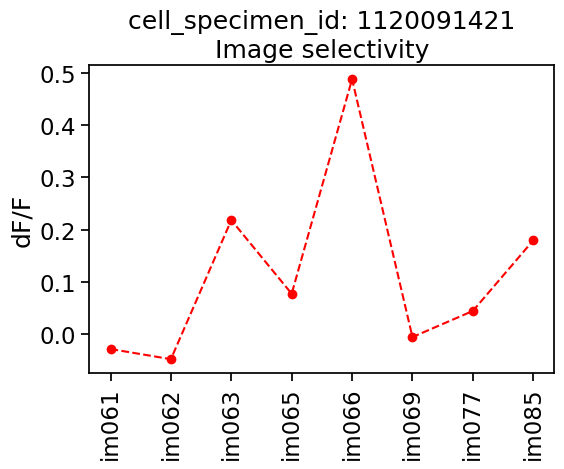

In [55]:
# Plot the mean response for each image
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(tuning_curve.index.values, tuning_curve.mean_response.values, 'or', linestyle='--')
ax.set_title('cell_specimen_id: '+str(cell_specimen_id)+'\nImage selectivity')
ax.set_xticklabels(tuning_curve.index.values, rotation=90)
ax.set_ylabel('dF/F')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Now plot the `mean_response` for each individual presentation of each image, along with the mean response. 

How variable is the cell activity across repeated presentations of a given image?

Bonus points for using `seaborn.scatterplot` function with the `stimulus_response_df` dataframe for this cell as the input: https://seaborn.pydata.org/generated/seaborn.scatterplot.html


In [56]:
cell_df.groupby(['image_name']).mean()[['mean_response']]

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_65770/2056889787.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cell_df.groupby(['image_name']).mean()[['mean_response']]


,mean_response
image_name,
im061,-0.027940
im062,-0.047340
im063,0.218232
im065,0.077610
im066,0.487417
im069,-0.005098
im077,0.044771
im085,0.179549


In [57]:
tuning_curve.index.values

array(['im061', 'im062', 'im063', 'im065', 'im066', 'im069', 'im077',
       'im085'], dtype=object)

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_65770/2808550347.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tuning_curve = cell_df.groupby(['image_name']).mean()[['mean_response']]
/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_65770/2808550347.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tuning_curve.index.values, rotation=90)


Text(0, 0.5, 'dF/F')

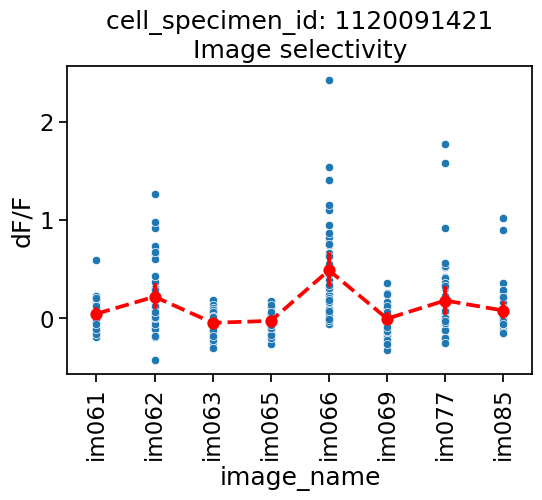

In [58]:
# Plot the mean response for each image

cell_df = stim_response_df[stim_response_df.cell_specimen_id==cell_specimen_id]
tuning_curve = cell_df.groupby(['image_name']).mean()[['mean_response']]

fig, ax = plt.subplots(figsize=(6,4))
ax = sns.scatterplot(data=cell_df, x='image_name', y='mean_response', ax=ax)
ax = sns.pointplot(data=cell_df, x='image_name', y='mean_response', color='r', linestyle='--', ax=ax)
ax.set_title('cell_specimen_id: '+str(cell_specimen_id)+'\nImage selectivity')
ax.set_xticklabels(tuning_curve.index.values, rotation=90)
ax.set_ylabel('dF/F')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

What could account for the trial to trial variability here? 

What do other cells tuning curves look like? 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Get the average image response for all cells in this experiment and plot it as a heatmap. 

Super mega bonus points if you use `pandas.groupby`, `pandas.pivot_table`, AND `seaborn.heatmap` for this

https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

https://seaborn.pydata.org/generated/seaborn.heatmap.html

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_65770/4068289767.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tuning_curves = stim_response_df.groupby(['cell_specimen_id', 'image_name']).mean()[['mean_response']]


<Axes: xlabel='image_name', ylabel='cell_specimen_id'>

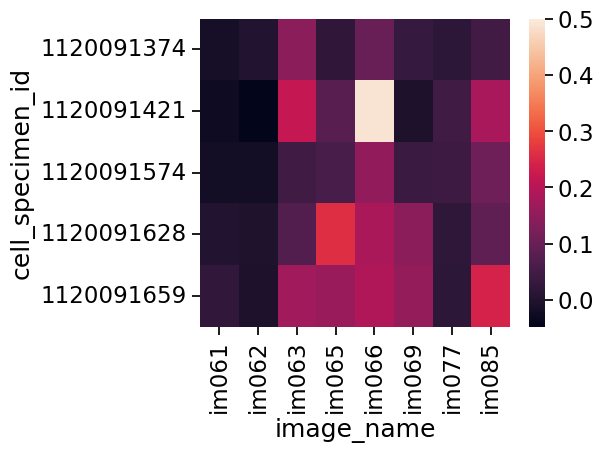

In [59]:
tuning_curves = stim_response_df.groupby(['cell_specimen_id', 'image_name']).mean()[['mean_response']]

tuning_curves = tuning_curves.pivot_table(values='mean_response', index='cell_specimen_id', columns='image_name')

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(data=tuning_curves, vmax=0.5, cbar=True, ax=ax)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

Does this pattern reflect the true selectivity of these cells, or is it just random chance? 

One way to test this is to ask whether image tuning differs depending on which trials you select

Let's try splitting the data, then plotting the same heatmap for the splits. Will it look the same?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> Splitting the data </h4>

Let's try splitting the data and checking if the tuning curves look the same when computed separately for each half of the dataset

/var/folders/bp/23y492js7lz2gvjzgsw6cg_m0000gp/T/ipykernel_65770/4068289767.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tuning_curves = stim_response_df.groupby(['cell_specimen_id', 'image_name']).mean()[['mean_response']]


<Axes: xlabel='image_name', ylabel='cell_specimen_id'>

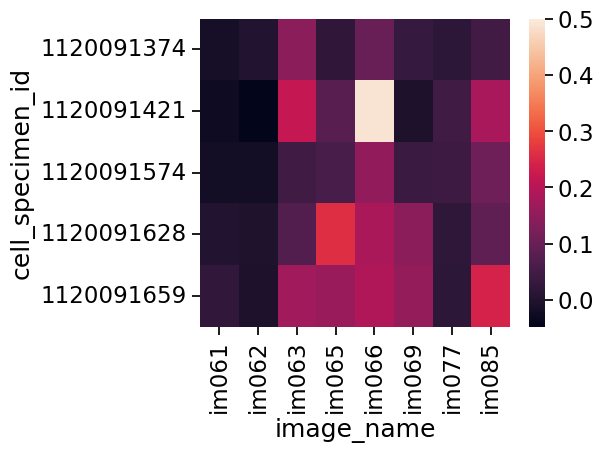

In [60]:
tuning_curves = stim_response_df.groupby(['cell_specimen_id', 'image_name']).mean()[['mean_response']]

tuning_curves = tuning_curves.pivot_table(values='mean_response', index='cell_specimen_id', columns='image_name')

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(data=tuning_curves, vmax=0.5, cbar=True, ax=ax)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FF0000; ">
<p>

Note - the next section is just copied from last year's materials, needs to be updated & refined

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> Quantifying variability </h4>

Computing $R^2$ is something that we are likely going to want to do many times. It is therefore helpful to write a function that tackles what we did earlier.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
 
By itself, though, simply computing the residual error on every point can be difficult to interpret.
    
One popular metric for assessing this kind of mode is the "coefficient of determination," or $R^2$. $R^2$ asks compares the sum of squared residuals in our model, $SS_{residuals}$, to the total sum of squares $SS_{total}$, effectively asking "How much of the variance in our data is explained by our model?." $R^2$ is defined:
    
 $$R^2 = 1-\frac{SS_{residuals}}{SS_{total}}$$

Because a perfect model will have zero residuals and worthless model will explain no variance, subtracting this ratio from 1 lends interpretability. A perfect model will have zero residuals, and therefore $R^2=1$. If no variance is explained $R^2$ will equal 0. Values in between can be interpreted as "fraction of variance explained."

We can use our tuning curve as a simple model of the receptive field if we use it like a look up table: for each stimulus direction, we know what the mean response of the cell will be. Using the index established above, we can query the tuning curve for the expected response amplitude of the cell.

One method for quantifying how well a prediction does is to simply compute the prediction error, that is, how far off the prediction was from the observed value. These are also called the model residuals.

In [63]:
def compute_coefficient_of_determination(mean_response,prediction):
    """
    Compute the coefficient of determination (R^2) for a set of data
    
    Parameters
    ----------
    mean_response : np.array
        The mean response for each stimulus
    prediction : np.array
        The predicted response for each stimulus
    
    Returns
    -------
    r2 : float
        The coefficient of determination
    """

    # Compute SS residuals
    residual = mean_response-prediction
    sum_of_squared_residual  =  np.mean((residual)**2)
    
    # Compute Total SS
    total = np.mean(mean_response)-mean_response
    sum_of_squared_total  =  np.mean((total)**2)
    
    # And finally R2
    r2 = 1-sum_of_squared_residual/sum_of_squared_total
    return r2

In [64]:
# # How well does a model fit on A predict B?
# r2_ab = compute_coefficient_of_determination(mean_response_b,prediction_ab)
# r2_ab

In [65]:
# # How well did this same model do at predicting itself?
# r2_aa

We call this technique for assessing models "data splitting". The segment of the data we built our model with is called the "training set," and the set of data we tested with is called the "testing set." 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h4> There is more than one way to split your data</h4>

Up till now, all our analysis has focus on data that were split into the first and second halves of the behavior session. 

How, exactly, you split your data can have a profound impact on the question you are asking. Here,this means that our question wasn't just about the consistency of data- it was about stability of neural responses between the first and second half of the session. 

One valid alternative would have been to grab random halves. Another might have been to grab alternating trials under each experiment condition. All of these would have told us something about neural consistency, but each would have asked subtly different questions about our data and each would have made subtly different assumptions going in. There is no one answer for the 'best' way to split your data. Instead, you will always need to formulate a split to answer your question at hand.

<b> You can use carful data splits to answer scientific questions. </b>

So far, we have thought about variability as a problem. Now though, lets try a strategic split across experimental conditions to see if we can learn something.
    
In this case, we are going to how an animals choice might impact the tuning of a cell.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FF0000; ">
<p>

This part is something new that Marina added

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h3> Does behavior choice affect stimulus response? </h3>

Let's try splitting the data based on whether each image change resulted in a <b>hit</b> or a <b>miss</b> and see if the mouse's behavioral choice influences the cell's response.


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

First we need to figure out whether the mouse correctly licked following each image change or not

Let's look at the `licks` and `rewards` attributes of the dataset object

In [66]:
# Timestamps of every lick in the session
dataset.licks.head()

,timestamps,frame
0,12.57131,194
1,20.21088,652
2,21.14499,708
3,22.19586,771
4,55.25611,2753


In [67]:
# Timestamps of every reward in the session
dataset.rewards.head()

,volume,timestamps,auto_rewarded
0,0.005,313.23364,True
1,0.005,320.75645,True
2,0.005,341.02302,True
3,0.005,350.01370,True
4,0.005,368.77903,True


To figure out which image changes had a correct lick or not (and thus correspond ot a hit or a miss), we would need to compare the onset times of each image change in the `stimulus_presentations` table to the lick times in the `licks` table (or the reward times in the `rewards` table) to see if there was a lick (or a reward) within 750ms of the stimulus onset. 

This is technically straightforward but can be tedious, so to save some time so that you can focus on asking interesting questions rather than data munging, we will provide you with some tools to annotate the `stimulus_presentations` table with things like lick and reward times for each image presentation. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>
<h4> Annotating stimulus presentations with behavior information </h4>
<p>

The `brain_observatory_utilities` package provides a useful tool to annotate the `stimulus_presentations` table with information about what happened during each stimulus, including timing of `licks`, `rewards`, and whether the trial was a <b>hit</b> or a <b>miss</b> trial. 

It will also add the average `running_speed` and `pupil_width` for each stimulus presentation. These can be used to filter data, or plot directly against cell activity to ask about he relationship between running and neural activity. 

The `get_annotated_stimulus_presentations` function can be found in the `datasets.behavior.data_formatting` module. It takes in the <b>dataset</b> object, which contains everything it needs to know about stimulus presentations, licks, rewards, running, etc., and returns an annotated version of the `stimulus_presentations` table.

In [68]:
import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Check documentation for the `get_annotated_stimulus_presentations` function. What is the input? What does it return?

Run the function to get the annotated `stimulus_presentations` table and assign it to a variable called `annotated_stim_table`. Inspect the columns.

In [83]:
behavior_utils.get_annotated_stimulus_presentations?

Signature:
behavior_utils.get_annotated_stimulus_presentations(
    ophys_experiment,
    epoch_duration_mins=10,
)
Docstring:
Takes in an ophys_experiment dataset object and returns the stimulus_presentations table with additional columns.
Adds several useful columns to the stimulus_presentations table, including the mean running speed and pupil diameter for each stimulus,
the times of licks for each stimulus, the rolling reward rate, an identifier for 10 minute epochs within a session,
whether or not a stimulus was a pre-change or pre or post omission, and whether change stimuli were hits or misses
:param ophys_experiment: obj
    AllenSDK BehaviorOphysExperiment object
    A BehaviorOphysExperiment instance
    See https://github.com/AllenInstitute/AllenSDK/blob/master/allensdk/brain_observatory/behavior/behavior_ophys_ophys_experiment.py  # noqa E501
:return: stimulus_presentations attribute of BehaviorOphysExperiment, with additional columns added
File:      ~/Documents/Code/brain

In [70]:
# Provide dataset object to run the function
annotated_stim_table = behavior_utils.get_annotated_stimulus_presentations(dataset)

In [71]:
# Look at the output
annotated_stim_table.head()

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,...,time_from_last_change,pre_change,licked,lick_on_next_flash,pre_omitted,post_omitted,reward_rate,engaged,engagement_state,epoch
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
1,1,change_detection_behavior,0,im065,-99,0.25021,309.366891,309.617101,17985,18000,...,NaN,False,False,False,False,<NA>,inf,True,engaged,0
2,1,change_detection_behavior,0,im065,-99,0.25022,310.117501,310.367721,18030,18045,...,NaN,False,False,False,False,False,inf,True,engaged,0
3,1,change_detection_behavior,0,im065,-99,0.25019,310.868141,311.118331,18075,18090,...,NaN,False,False,False,False,False,inf,True,engaged,0
4,1,change_detection_behavior,0,im065,-99,0.25020,311.618751,311.868951,18120,18135,...,NaN,False,False,False,False,False,inf,True,engaged,0
5,1,change_detection_behavior,0,im065,-99,0.25022,312.369321,312.619541,18165,18180,...,NaN,True,False,False,False,False,inf,True,engaged,0


In [72]:
# Look at all the useful new columns!
annotated_stim_table.columns

Index(['stimulus_block', 'stimulus_block_name', 'image_index', 'image_name',
       'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'trials_id', 'active',
       'stimulus_name', 'is_sham_change', 'licks', 'mean_running_speed',
       'mean_pupil_width', 'change_time', 'go', 'catch', 'aborted',
       'auto_rewarded', 'hit', 'miss', 'false_alarm', 'correct_reject',
       'response_time', 'response_latency', 'reward_time', 'reward_volume',
       'time_from_last_change', 'pre_change', 'licked', 'lick_on_next_flash',
       'pre_omitted', 'post_omitted', 'reward_rate', 'engaged',
       'engagement_state', 'epoch'],
      dtype='object')

To be able to sort cell activity based on whether each image change in the stimulus table was a hit or a miss, we will want to recompute our `stimulus_response_df` and merge with this new annotated table instead of the original one.

In [73]:
# Get the stimulus response dataframe just for image changes
stim_response_df = data_formatting.get_stimulus_response_df(dataset, data_type='dff', event_type='changes',
                                                            time_window=[-1, 1], response_window_duration=0.5,
                                                            interpolate=True, output_sampling_rate=None)

# Merge it with the annotated stim table so you can filter cell responses based on behavior choice                                                       
stim_response_df = stim_response_df.merge(annotated_stim_table, on='stimulus_presentations_id')


100%|██████████| 5/5 [00:00<00:00, 37.92it/s]


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Limit the `stimulus_response_df` to image changes, then split by hit & miss trials. 

Plot our cell's image tuning curve (and the variability around the mean) similarly to how we did above, but now show hits and misses using different colors

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> Are other cells in this session affected by choice? </h4>

Instead of look at each cell's response one by one, we can also compute a metric of choice modulation. 

A simple modulation index can be computed by taking the average response in one condition, subtracting the average response in another condition, then dividing by the sum of the two. 
This gives a metric between -1 and 1 that tells you if the cell response was stronger in the first or second condition. 

Let's compute a choice modulation index for all our cells using this approach.

Limit the data to image changes, then split by hit vs. miss

Plot the tuning curve (and variability around the mean) for hits vs. misses. Is anything different? 

Compute a metric of hit vs. miss response

Pick the cell with the largest value of this index and plot it's tuning curve


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Pick the cell with the largest value of the choice modulation index and plot it's imaging tuning curve on hit vs. miss trials. 

Is anything different? Are all images affected equally, or is there an interaction between image identity and choice?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h3> Are cells tuned for running speed? </h3>

Another factor that could influence neural variability and contribute to neural encoding is locomotor behavior. Many studies have shown that animal movement and overall arousal state can influence the gain of sensory tuning. Running and other movements are also directly encoded by some neurons in the visual cortex, independent of stimulus identity. 

The dataset object contains info about the mouse's `running_speed`, in addition to information about pupil diameter and gaze location in the `eye_tracking` attribute. Running speed and pupil diameter are typically correlated, and both can be used as measures of overall arousal and behavioral state. 

Let's plot the activity of our Sst cells as a function of the mouse's running speed to see if these neurons encode running speed.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Get the `running_speed` attribute of the dataset object and plot the running speed. 
Remember that running speed is sampled at the stimulus display frequency, so you can use `stimulus_timestamps` to plot time on the x-axis. 

Text(0.5, 1.0, 'Ophys experiment ID 1080945462')

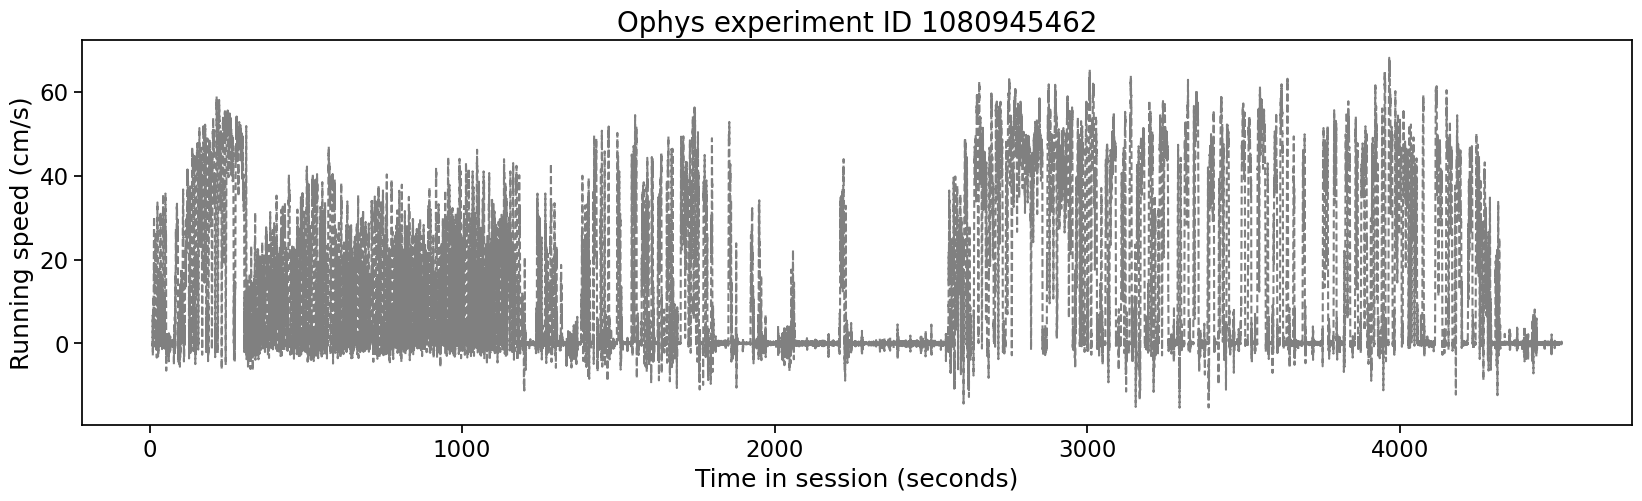

In [74]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(dataset.stimulus_timestamps, dataset.running_speed['speed'], color='gray', linestyle='--')
ax.set_xlabel('Time in session (seconds)')
ax.set_ylabel('Running speed (cm/s)')
ax.set_title('Ophys experiment ID {}'.format(ophys_experiment_id), fontsize = 20)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Examine the `eye_tracking` attribute of the dataset object. What are the columns? 

Plot `pupil_area` over time. 

In [75]:
dataset.eye_tracking.head()

,timestamps,cr_area,eye_area,pupil_area,likely_blink,pupil_area_raw,cr_area_raw,eye_area_raw,cr_center_x,cr_center_y,...,eye_center_x,eye_center_y,eye_width,eye_height,eye_phi,pupil_center_x,pupil_center_y,pupil_width,pupil_height,pupil_phi
frame,,,,,,,,,,,,,,,,,,,,,
0,0.18393,130.298881,69377.698731,33673.240498,False,33673.240498,130.298881,69377.698731,239.119872,261.345519,...,251.507367,249.450037,162.755074,135.686138,-0.112888,252.891831,249.216575,94.347357,103.530311,-0.057726
1,0.19730,120.969632,69424.125570,32157.121188,False,32157.121188,120.969632,69424.125570,239.060212,261.688425,...,251.739167,249.518556,162.106561,136.320118,-0.114363,253.686626,249.194154,95.002512,101.172771,-0.009237
2,0.20457,118.469282,69532.491033,30610.926197,False,30610.926197,118.469282,69532.491033,238.667035,261.626304,...,251.765705,248.607848,162.768950,135.977281,-0.103537,252.373206,248.036840,94.481371,98.710488,-0.157400
3,0.23025,109.225777,69369.036385,32355.697657,False,32355.697657,109.225777,69369.036385,238.783878,261.975695,...,252.266157,249.065804,162.359517,135.999728,-0.095117,251.198744,250.107586,94.488796,101.484671,0.138696
4,0.26757,112.396794,69396.405593,30382.966716,False,30382.966716,112.396794,69396.405593,238.387263,261.896105,...,251.472874,249.306866,162.014394,136.343206,-0.121260,251.878161,248.939072,94.486745,98.342253,-0.053665


Text(0.5, 1.0, 'Ophys experiment 1080945462')

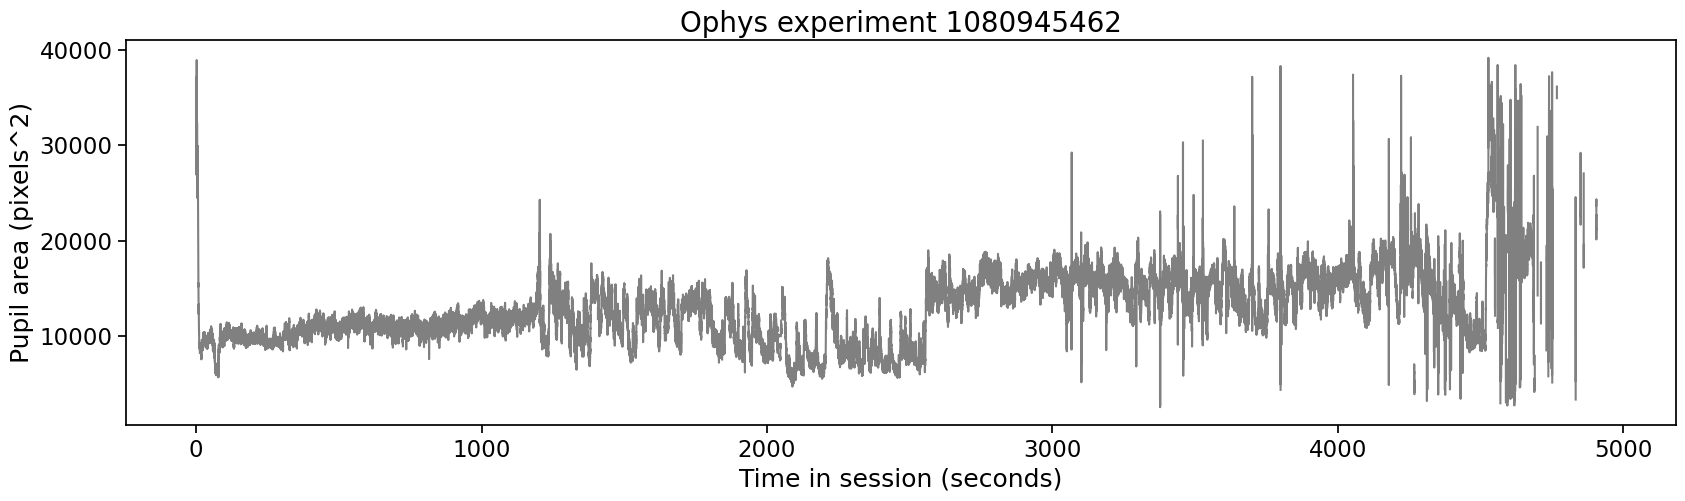

In [76]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(dataset.eye_tracking.timestamps, dataset.eye_tracking.pupil_area, color='gray')
ax.set_xlabel('Time in session (seconds)')
ax.set_ylabel('Pupil area (pixels^2)')
ax.set_title('Ophys experiment {}'.format(ophys_experiment_id), fontsize = 20)

Note that there are some very large spikes in the pupil area in some parts of the session. These are probably artifacts of the pupil detection algorithm, and could be filtered out using `scipy.signal.medfilt`: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

<h4> Run speed tuning </h4>

One way to look at speed tuning would be to bin the running speed into 5 cm/second bins, then compute the average cell activity in each of those bins. 

Alternatively, we could use the `stimulus_response_df` that we generated above, which contains the mean response for each stimulus presentation, along with the `annotated_stimulus_presentations` table that we merged into it, which contains the mean running speed for each stimulus presentation, and just plot the two against each other.


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

What accounts for the variability in this data? 

Try coloring the points in this plot based on other stimulus or behavioral metadata, such as `image_name` or `mean_pupil_area`

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot the binned cell response versus the running speed 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Part 3 -  Quantifying single cell coding with regression models </h2>

Questions: 

(1) How can linear regression be used to model neural coding? 

(2) How do you ensure that your model is valid and is not overfitting?

(3) How well can you predict neural activity based on stimulus information? Behavioral information? 

(4) Does the prediction improve when additional variables are included? (multiple linear regression)



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> Linear regression </h3>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>


In a regression problem, we are given pairs of data points $(\vec{x}_i, y_i)$ where $i \in [1,N]$.  We want to develop a function $f(\vec{x})$ such that $f(\vec{x}_i)\approx y_i$ for each pair of points in the data set.
</p>
<p>
The simplest regression problem is linear regression, in which we try to create the function $f$ by linearly combining a set of functions that act on the points $x$.

$f(\vec{x}_i) = \sum_j w_j \phi(\vec{x}_i)$

The functions $\phi(\vec{x})$ are chosen according to the analysis.  They are often called "features".  The coefficients $w_j$ are called "weights".

You may be familiar with a version of linear regression where the functions $\phi$ are chosen to be the identity and a constant.  When the input space is one dimensional this is:

$f(x) = w x + b$
</p>
<p>
    This problem is defined by an "error function", whose minimization tries to force the function $f$ to approximate the data points $y_i$ on the inputs $\vec{x}_i$.  This error function is

$E = \frac{1}{2} \sum_i \left | y_i - f\left ( \vec{x}_i \right ) \right |^2 = \frac{1}{2} \sum_i \left | y_i - \sum_j w_j \phi (\vec{x}_i ) \right |^2 $
</p>
<p>
    This particular problem has an exact analytic solution that is easy to implement, but in this tutorial, we will look at how to perform regression using the `scikit-learn` Python package.  `scikit-learn` has many regression algorithms in common use built in, most of which do not have simple analytic solutions.  In addition, other packages have adopted the `scikit-learn` style interface.  One advantage of this is that multiple algorithms can be deployed with the same code.
</p>

<p>
The `scikit-learn` website:  http://scikit-learn.org/stable/
</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FF0000; ">
<p>
<h2> Extra stuff - tutorial on other `brain_observatory_utilities`` functions </h2>


In [77]:
import brain_observatory_utilities.utilities.general_utilities as general_utilities

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>
<h4> Get an event triggered response for one cell </h4>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

We can use the `build_tidy_cell_df` function to get a "tidy" (aka "long form") dataframe where each row is 1 observation (i.e. one ophys timepoint). 

The function takes in the entire ophys dataset object, and extracts the values for `dff`, `events`, and `filtered_events` from the relevant attribtues of the dataset object, along with the `ophys_timestamps` and cell IDs.

In [78]:
tidy_cell_df = data_formatting.build_tidy_cell_df(dataset)
tidy_cell_df

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id
0,9.31877,0.716071,0.000000,0.000000,1115349817,1120091374
1,9.41227,0.676236,0.000000,0.000000,1115349817,1120091374
2,9.50577,0.388254,0.000000,0.000000,1115349817,1120091374
3,9.59926,0.091583,0.000000,0.000000,1115349817,1120091374
4,9.69276,0.178744,0.000000,0.000000,1115349817,1120091374
...,...,...,...,...,...,...
48200,4517.20282,3.257478,2.377717,1.711161,1115349854,1120091659
48201,4517.29635,5.974512,3.375375,3.063211,1115349854,1120091659
48202,4517.38987,5.079509,0.000000,0.932377,1115349854,1120091659
48203,4517.48340,3.948772,0.000000,0.046022,1115349854,1120091659


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

We can then pass the `tidy_cell_df` into the `general_utilities` function called `event_triggered_response`

Let's look at the documentation for the `event_triggered_response` function

In [79]:
# Let's look at the documentation for the event_triggered_response function
utils.event_triggered_response?

Object `utils.event_triggered_response` not found.


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>

The `data` argument should a tidy pandas dataframe, like the one we produced above using `build_tidy_cell_df`. Each row is one observation and the values are a timeseries for one cell. 

Note that this means that the `tidy_cell_df` we created above needs to be filtered to only include one cell before providing to the `event_triggered_response` function.

The `y` argument is the column `data` to use for cell responses. Let's use `dff_traces` here. 

The `t` argument is the column of `data` that corresponds to the observations (i.e. timestamps). When we created our `tidy_cell_df`, the `timestamps` column was pulled from the `ophys_timestamps` array for this experiment. 

The `event_times` argument should be a list of event times that does not have to correspond directly to the times in the timestamps provided in `data`. In our case, we want to use stimulus onset times from the `stimulus_presentations` table. You could also use lick times or any other event that occured in the session. 

The `event_triggered_response` function also requires you to provide a value for `t_before` and `t_after` which are the times, in seconds, before and after each event over which you would like to extract each cell's response for. Here we can use +/- 1 second.

If the `interpolate` argument is set to `True` (which is the default value), and a value is also provided for `output_sampling_rate`, the `event_triggered_response` funciton will automatically interpolate the timeseries provided in `data` to the provided `output_sampling_rate`. Setting `interpolate` to `False` means that the native frame rate of the data will be used. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Use the `event_triggered_response` function to get stimulus aligned dff traces for the `cell_specimen_id` we identified above.

First filter the `stimulus_table` to get the event times for image changes, and provide those event times to the `event_triggered_response` function, along with the `tidy_cell_df` we created above.


In [80]:
# Let's remind ourselves whats in the tidy_cell_df
tidy_cell_df.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id
0,9.31877,0.716071,0.0,0.0,1115349817,1120091374
1,9.41227,0.676236,0.0,0.0,1115349817,1120091374
2,9.50577,0.388254,0.0,0.0,1115349817,1120091374
3,9.59926,0.091583,0.0,0.0,1115349817,1120091374
4,9.69276,0.178744,0.0,0.0,1115349817,1120091374


In [81]:
# Get the change onset times from the stimulus table
changes = stimulus_table[stimulus_table.is_change==True]
start_times = changes.start_time.values
# Look at the first 10 change times
print(start_times[:10])
# Look at the filtered stim table
changes.head()

[313.1199508 320.6260908 340.8926508 349.9000008 368.6653208 376.9220808
 394.1861808 402.4429308 429.4816708 449.7482608]


,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,stimulus_name,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
6,1,change_detection_behavior,1,im077,-99,0.25019,313.119951,313.370141,18210,18225,True,False,False,-99,0,0,True,Natural_Images_Lum_Matched_set_training_2017,False
16,1,change_detection_behavior,4,im063,-99,0.25020,320.626091,320.876291,18660,18675,True,False,False,-99,0,1,True,Natural_Images_Lum_Matched_set_training_2017,False
43,1,change_detection_behavior,5,im062,-99,0.25018,340.892651,341.142831,19875,19890,True,False,False,-99,0,7,True,Natural_Images_Lum_Matched_set_training_2017,False
55,1,change_detection_behavior,3,im061,-99,0.25020,349.900001,350.150201,20415,20430,True,False,False,-99,0,8,True,Natural_Images_Lum_Matched_set_training_2017,False
80,1,change_detection_behavior,2,im066,-99,0.25021,368.665321,368.915531,21540,21555,True,False,False,-99,0,12,True,Natural_Images_Lum_Matched_set_training_2017,False


In [82]:
# Create event triggered response table
etr = general_utilities.event_triggered_response(data=tidy_cell_df[tidy_cell_df.cell_specimen_id==cell_specimen_id], 
                                                t='timestamps', y='dff',
                                                event_times=start_times, t_before=1, t_after=1, interpolate=False)
etr.head()

,time,dff,event_number,original_index,event_time
0,-0.935246,-0.340866,0,0,313.119951
1,-0.841721,-0.223313,0,0,313.119951
2,-0.748197,-0.095151,0,0,313.119951
3,-0.654672,3.008054,0,0,313.119951
4,-0.561147,1.271310,0,0,313.119951


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>

Plot the average change evoked response for the `cell_specimen_id` we identified above.

I forget how to do this.... better to use stim_response_df function